<a href="https://colab.research.google.com/github/AllanKamimura/Pai_ta_ON_python/blob/main/school/SAA0183_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone http://github.com/AllanKamimura/utils.git
!pip install ambiance

from ambiance import Atmosphere
from utils.myutils import *

import scipy.optimize

Cloning into 'utils'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 1), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (6/6), 1.66 KiB | 849.00 KiB/s, done.


In [19]:
import sympy as sp
from sympy.printing import print_latex
pi = sp.pi
sea = Atmosphere(0)

In [3]:
AR     = 8.90;
e      = 0.85;
CD0    = 0.025;
MTOW   = 450300 #N;
BOW    = 320300 #N;
FUEL_W = 130000 #N;
FUEL_M = float(FUEL_W / sea.grav_accel)
T_MSL  = 92300 #N;
S      = 92.5 #m2;
TSFC   = 0.85 / 3600 #N/(s*N);
M      = 0.79
K      = 1 / (np.pi * AR * e)

In [4]:
T, W, V = sp.symbols("T, W, V")
gamma, Gamma = sp.symbols("\\gamma, \\Gamma")
rho = sp.symbols("\\rho")
Em = sp.symbols("E_m")

subs = {
    Gamma: 1 + sp.sqrt(1 + 12 * CD0 * K / ((T/W) ** 2)),
    Em: sp.pi * AR * e / (4 * CD0)
    }

eq1 = sp.Eq(V, sp.sqrt(T/S * Gamma / (3*rho*CD0))).subs(subs)
eq2 = sp.Eq(sp.sin(gamma), T/W * (1 - Gamma/6) - 3 / (2 * Gamma * Em ** 2 * (T/W))).subs(subs)

V_eq = sp.lambdify([W, T, rho] , eq1.rhs)
sinG = sp.lambdify([W, T] , eq2.rhs)

In [66]:
def T_h(h, sigma):
    if h / 0.3048 > 36089:
        return float(T_MSL * sigma ** 0.7)

    else:
        return float(T_MSL * sigma * 1.439)

def create_table(fase, tempo_, consumo_, distancia_):
    table = f"""\\subsubsection{{Resumo dos resultados}}
\\begin{{table}}[H]
\\centering
\\caption{{{fase}: resumo}}
\\begin{{tabular}}{{ccc}}
\\textbf{{Variavel}} & \\textbf{{Valor}} & \\textbf{{Unidade}} \\\\\\hline
Tempo total & {tempo_:.0f} & s \\\\
Consumo total & {consumo_:.0f} & N \\\\
Distancia & {distancia_:.0f} & km
\\end{{tabular}}
\\end{{table}}"""
    print(table)

In [109]:
altitude = 0
curr_FUEL = FUEL_M
curr_W = BOW + curr_FUEL * float(sea.grav_accel)
dt = 1

tempo_total = 0
distancia   = 0
consumo     = 0
consumo_list = [consumo]
distancia_list = [distancia]
tempo_list = [tempo_total]

yy1 = []
yy2 = []
xx1 = []
#subida
while altitude < 41000 * 0.3048:
    curr_atm = Atmosphere(altitude)
    sigma    = (curr_atm.density * 1/(1+15/curr_atm.temperature)) / (sea.density * 1/(1+15/sea.temperature))

    curr_T   = T_h(altitude, sigma)

    curr_sinG = float(sinG(curr_W, curr_T))
    curr_V    = float(V_eq(curr_W, curr_T, curr_atm.density * 1/(1+15/curr_atm.temperature)))

    altitude  += curr_V * curr_sinG * dt
    distancia += curr_V * (1 - curr_sinG**2)**0.5 * dt

    dm = float(TSFC * curr_T * dt)

    tempo_total += dt
    curr_W      -= dm
    consumo     += dm

consumo_list.append(consumo)
distancia_list.append(distancia)
tempo_list.append(tempo_total)

#cruzeiro
Emax = 1 / (2 * np.sqrt(CD0 * K))

def max_alcance_f(CL):
    return -CL ** 0.5 / (CD0 + K * CL ** 2)

res = scipy.optimize.minimize(max_alcance_f, 0.4)
dCL = 0.1
CL  = np.linspace(res.x * 0.8, res.x * 1.2, 200)
CD  = CD0 + K * CL ** 2

d  = curr_atm.density * 1/(1+15/curr_atm.temperature)
W1 = curr_W
W2 = BOW + 0.12 * FUEL_W
v1 = np.sqrt(2 * W1 / (d * S * CL))
epsilon = 1 - W2/W1
v2 = v1 * np.sqrt(1 - epsilon)
E  = CL / CD

x = 2 * E * v1 / (TSFC) * (1 - np.sqrt(1 - epsilon))
# plt.plot(v1, x / 1000)
# plt.xlabel("$V_1$ [m/s]")
# plt.ylabel("alcance [km]")
# plt.title("Alcance para cruzeiro com altitude e $C_L$ constante")

max_alcance = np.max(x)
find_lrc    = np.isclose(x, max_alcance * 0.99, atol = 1000)
v1_lrc      = float(v1[find_lrc].max())
v2_lrc      = float(v2[find_lrc].max())
x_lrc       = float(x[find_lrc].min())

# plt.scatter(v1_lrc, x_lrc /1000, color = "orange", zorder = 100, label = "LRC")
# plt.text(v1_lrc*1.005, x_lrc / 1000, f"({v1_lrc:.0f}, {x_lrc/1000:.0f})")
# plt.legend()

distancia  += x_lrc
curr_W      = W2
consumo     = 0.88 * FUEL_W
tempo_total+= 2 * x_lrc / (v1_lrc + v2_lrc)

consumo_list.append(consumo)
distancia_list.append(distancia)
tempo_list.append(tempo_total)

# descida
while altitude > 2000 * 0.3048:
    curr_atm = Atmosphere(altitude)
    d = float(curr_atm.density * 1/(1+15/curr_atm.temperature))
    sigma    = d / float(sea.density * 1/(1+15/sea.temperature))

    curr_T   = T_h(altitude, sigma) * 0.05

    CD = CD0 + (2*curr_W/(d*S*curr_V**2)) ** 2 / (np.pi * AR * e)
    curr_D = 1/2 * d*S*curr_V**2 * CD

    if altitude / 0.3048 > 36089:
        a = 0
    else:
        a = -0.133184 * float(curr_V/curr_atm.speed_of_sound) ** 2

    vh = curr_V * (curr_T - curr_D) / curr_W / (1 + a)

    altitude  += vh * dt
    distancia += (curr_V**2 - vh**2)**0.5 * dt

    curr_V += a * float(curr_atm.grav_accel) / curr_V * vh * dt
    dm = float(TSFC * curr_T * dt)

    tempo_total += dt
    curr_W      -= dm
    consumo     += dm


consumo_list.append(consumo)
distancia_list.append(distancia)
tempo_list.append(tempo_total)

distancia_2 = 0
# subida 2
while altitude < 20000 * 0.3048:
    curr_atm = Atmosphere(altitude)
    sigma    = (curr_atm.density * 1/(1+20/curr_atm.temperature)) / (sea.density * 1/(1+20/sea.temperature))

    curr_T   = T_h(altitude, sigma)

    curr_sinG = float(sinG(curr_W, curr_T))
    curr_V    = float(V_eq(curr_W, curr_T, curr_atm.density * 1/(1+20/curr_atm.temperature)))

    altitude  += curr_V * curr_sinG * dt
    distancia += curr_V * (1 - curr_sinG**2)**0.5 * dt
    distancia_2   += curr_V * (1 - curr_sinG**2)**0.5 * dt

    dm = float(TSFC * curr_T * dt)

    tempo_total += dt
    curr_W      -= dm
    consumo     += dm

consumo_list.append(consumo)
distancia_list.append(distancia)
tempo_list.append(tempo_total)

#cruzeiro 2
res = scipy.optimize.minimize(max_alcance_f, 0.4)
dCL = 0.1
CL  = np.linspace(res.x * 0.8, res.x * 1.2, 200)
CD  = CD0 + K * CL ** 2

d  = curr_atm.density * 1/(1+15/curr_atm.temperature)
W1 = curr_W
W2 = curr_W - 6252
v1 = np.sqrt(2 * W1 / (d * S * CL))
epsilon = 1 - W2/W1
v2 = v1 * np.sqrt(1 - epsilon)
E  = CL / CD

x = 2 * E * v1 / (TSFC) * (1 - np.sqrt(1 - epsilon))
# plt.plot(v1, x / 1000)
# plt.xlabel("$V_1$ [m/s]")
# plt.ylabel("alcance [km]")
# plt.title("Alcance para cruzeiro com altitude e $C_L$ constante")

max_alcance = np.max(x)
find_lrc    = np.isclose(x, max_alcance * 0.99, atol = 1000)
v1_lrc      = float(v1[find_lrc].max())
v2_lrc      = float(v2[find_lrc].max())
x_lrc       = float(x[find_lrc].min())

# print(v1_lrc)
# print(v2_lrc)
# plt.scatter(v1_lrc, x_lrc /1000, color = "orange", zorder = 100, label = "LRC")
# plt.text(v1_lrc*1.005, x_lrc / 1000, f"({v1_lrc:.0f}, {x_lrc/1000:.0f})")
# plt.legend()

distancia  += x_lrc
curr_W      = W2
consumo    += (W2 - W1)
tempo_total+= 2 * x_lrc / (v1_lrc + v2_lrc)

consumo_list.append(consumo)
distancia_list.append(distancia)
tempo_list.append(tempo_total)

# descida 2
while altitude > 10000 * 0.3048:
    curr_atm = Atmosphere(altitude)
    d = float(curr_atm.density * 1/(1+15/curr_atm.temperature))
    sigma    = d / float(sea.density * 1/(1+15/sea.temperature))

    curr_T   = T_h(altitude, sigma) * 0.05

    CD = CD0 + (2*curr_W/(d*S*curr_V**2)) ** 2 / (np.pi * AR * e)
    curr_D = 1/2 * d*S*curr_V**2 * CD

    if altitude / 0.3048 > 36089:
        a = 0
    else:
        a = -0.133184 * float(curr_V/curr_atm.speed_of_sound) ** 2

    vh = curr_V * (curr_T - curr_D) / curr_W / (1 + a)

    altitude  += vh * dt
    distancia += (curr_V**2 - vh**2)**0.5 * dt

    curr_V += a * float(curr_atm.grav_accel) / curr_V * vh * dt
    dm = float(TSFC * curr_T * dt)

    tempo_total += dt
    curr_W      -= dm
    consumo     += dm

consumo_list.append(consumo)
distancia_list.append(distancia)
tempo_list.append(tempo_total)

#max endurance
W1 = 329000 + 540
W2 = BOW + 251
v_endurance = (2 * curr_W / (d * S)) ** 0.5 * (K/CD0) ** 0.25
epsilon = 1 - W2/W1
t_endurance = float(2*Emax/TSFC * np.arctan(0.5*epsilon/(1-0.5*epsilon)))
tempo_total += t_endurance
consumo += (W1 - W2)
distancia += (v_endurance * t_endurance)

consumo_list.append(consumo)
distancia_list.append(distancia)
tempo_list.append(tempo_total)

while altitude > 2000 * 0.3048:
    curr_atm = Atmosphere(altitude)
    d = float(curr_atm.density * 1/(1+15/curr_atm.temperature))
    sigma    = d / float(sea.density * 1/(1+15/sea.temperature))

    curr_T   = T_h(altitude, sigma) * 0.05

    CD = CD0 + (2*curr_W/(d*S*curr_V**2)) ** 2 / (np.pi * AR * e)
    curr_D = 1/2 * d*S*curr_V**2 * CD

    if altitude / 0.3048 > 36089:
        a = 0
    else:
        a = -0.133184 * float(curr_V/curr_atm.speed_of_sound) ** 2

    vh = curr_V * (curr_T - curr_D) / curr_W / (1 + a)

    altitude  += vh * dt
    distancia += (curr_V**2 - vh**2)**0.5 * dt

    curr_V += a * float(curr_atm.grav_accel) / curr_V * vh * dt
    dm = float(TSFC * curr_T * dt)

    tempo_total += dt
    curr_W      -= dm
    consumo     += dm

    xx1.append(tempo_total)
    yy1.append(consumo)
    yy2.append(altitude)

consumo_list.append(consumo)
distancia_list.append(distancia)
tempo_list.append(tempo_total)

Text(0, 0.5, 'consumido ($N$)')

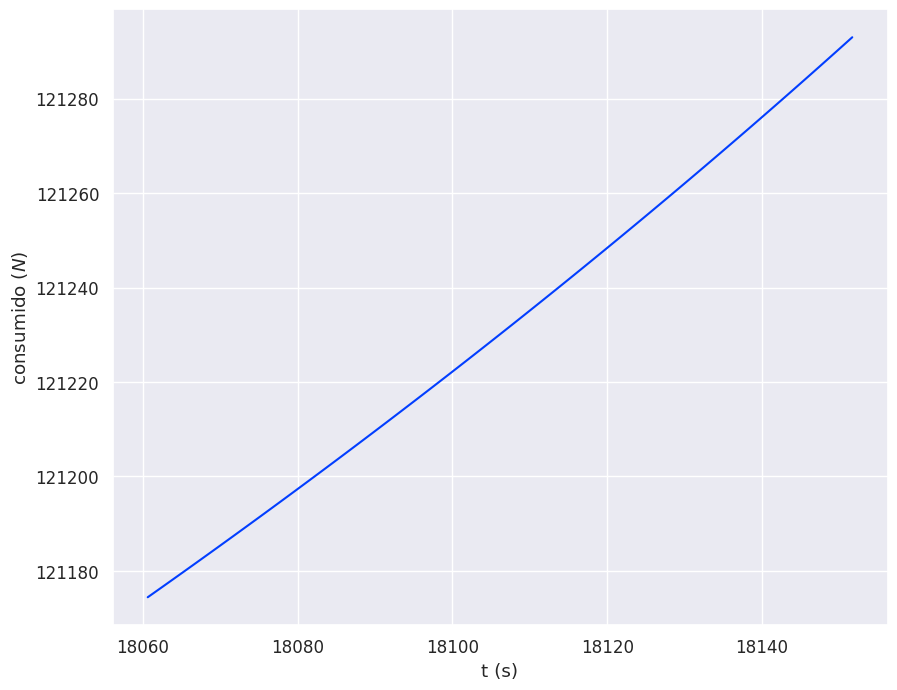

In [111]:
plt.plot(xx1,np.array(yy1))
plt.xlabel("t (s)")
plt.ylabel("consumido ($N$)")

# plt.plot(xx1,np.array(yy2) / 0.3048)
# plt.xlabel("t (s)")
# plt.ylabel("altitude ($ft$)")

In [130]:
# create tables
tempos = np.array(tempo_list[1:]) - np.array(tempo_list[:-1])
consumos = np.array(consumo_list[1:]) - np.array(consumo_list[:-1])
distancias = (np.array(distancia_list[1:]) - np.array(distancia_list[:-1]))/1000
fases = ["Decolagem 1", "Cruzeiro 1", "Descida 1", "Subida 2", "Cruzeiro 2", "Descida 2", "Endurance 1", "Descida 3"]

for i in range(8):
    tempo_ = tempo_list[i+1]
    consumo_ = consumo_list[i+1]
    distancia_ = distancia_list[i+1]
    fase_  = fases[i]
    print(f"{fase_}, {tempo_:.0f}, {distancia_/1000:.0f}, {consumo_:.0f}")

print()
for i in range(8):
    tempo_ = tempos[i]
    consumo_ = consumos[i]
    distancia_ = distancias[i]
    fase_  = fases[i]
    create_table(fase_, tempo_, consumo_, distancia_)
    print()

Decolagem 1, 743, 147, 10971
Cruzeiro 1, 14528, 4099, 114400
Descida 1, 14979, 4203, 114718
Subida 2, 15141, 4233, 118279
Cruzeiro 2, 16092, 4403, 112027
Descida 2, 16254, 4434, 112184
Endurance 1, 18060, 4621, 121173
Descida 3, 18152, 4639, 121293

\subsubsection{Resumo dos resultados}
\begin{table}[H]
\centering
\caption{Decolagem 1: resumo}
\begin{tabular}{ccc}
\textbf{Variavel} & \textbf{Valor} & \textbf{Unidade} \\\hline
Tempo total & 743 & s \\
Consumo total & 10971 & N \\
Distancia & 147 & km
\end{tabular}
\end{table}

\subsubsection{Resumo dos resultados}
\begin{table}[H]
\centering
\caption{Cruzeiro 1: resumo}
\begin{tabular}{ccc}
\textbf{Variavel} & \textbf{Valor} & \textbf{Unidade} \\\hline
Tempo total & 13785 & s \\
Consumo total & 103429 & N \\
Distancia & 3952 & km
\end{tabular}
\end{table}

\subsubsection{Resumo dos resultados}
\begin{table}[H]
\centering
\caption{Descida 1: resumo}
\begin{tabular}{ccc}
\textbf{Variavel} & \textbf{Valor} & \textbf{Unidade} \\\hline
Tempo

In [131]:
tempos

array([  743.    , 13785.046 ,   451.    ,   162.    ,   951.0782,   162.    ,  1805.5209,    92.    ])

In [127]:
(130000 - 121293) / 130000 * 100

6.697692307692307

In [122]:
18152 / 60 / 60

5.042222222222223

In [125]:
4639 - 187

4452